In [1]:
from src.model import PyTradeShifts
from src.postprocessing import Postprocessing
import pandas as pd
import os
os.chdir('../')
os.chdir('../')

In [19]:
ISIMIP = pd.read_csv(
        "." + "/data/scenario_files/ISIMIP_climate/ISIMIP_wheat_Hedlung.csv",
        index_col=0,
    )
nan_indices = ISIMIP.index[ISIMIP.iloc[:, 0].isnull()].tolist()
Wheat2018 = PyTradeShifts(
    "Wheat",
    2018,
    region="Global",
    testing=False,
    countries_to_remove=nan_indices,
    cd_kwargs={"seed": 2},
    make_plot=False,
)
ISIMIP = PyTradeShifts(
    crop="Wheat",
    base_year=2018,
    scenario_file_name="ISIMIP_climate/ISIMIP_wheat_Hedlung.csv",
    scenario_name="ISIMIP",
    countries_to_remove=nan_indices,
    cd_kwargs={"seed": 2},
    make_plot=False,
)
# isimip without removed countries -- it serves only the purpose of having multiple scenarios to compare
ISIMIP_2 = PyTradeShifts(
    crop="Wheat",
    base_year=2018,
    scenario_file_name="ISIMIP_climate/ISIMIP_wheat_Hedlung.csv",
    scenario_name="ISIMIP",
    countries_to_remove=nan_indices,
    cd_kwargs={"seed": 2},
    make_plot=False,
)

Loaded data for Wheat in Y2018.
Removed 0 countries with no trade or production.
No countries removed.
Prebalanced trade matrix.
Corrected re-exports.
Removed 133 countries from the trade matrix.
Removed countries with trade below the 75th percentile.
Built trade graph.
Found 6 trade communities.
Loaded data for Wheat in Y2018.
Removed 0 countries with no trade or production.
No countries removed.
Prebalanced trade matrix.
Corrected re-exports.
Removed 133 countries from the trade matrix.
Removed countries with trade below the 75th percentile.
Applied scenario ISIMIP.
Built trade graph.
Found 5 trade communities.
Loaded data for Wheat in Y2018.
Removed 0 countries with no trade or production.
No countries removed.
Prebalanced trade matrix.
Corrected re-exports.
Removed 133 countries from the trade matrix.
Removed countries with trade below the 75th percentile.
Applied scenario ISIMIP.
Built trade graph.
Found 5 trade communities.


In [20]:
comparison = Postprocessing([Wheat2018, ISIMIP, ISIMIP_2])

Starting postprocessing computations...


As we can see it is difficult to track countries between scenarios as colours are arbitrarily assigned.
That's where anchor countries come in.
User-specified list of countries that the script attempts to keep the same colour between scenarios.
Let's make Postprocessing class again, this time with anchors.

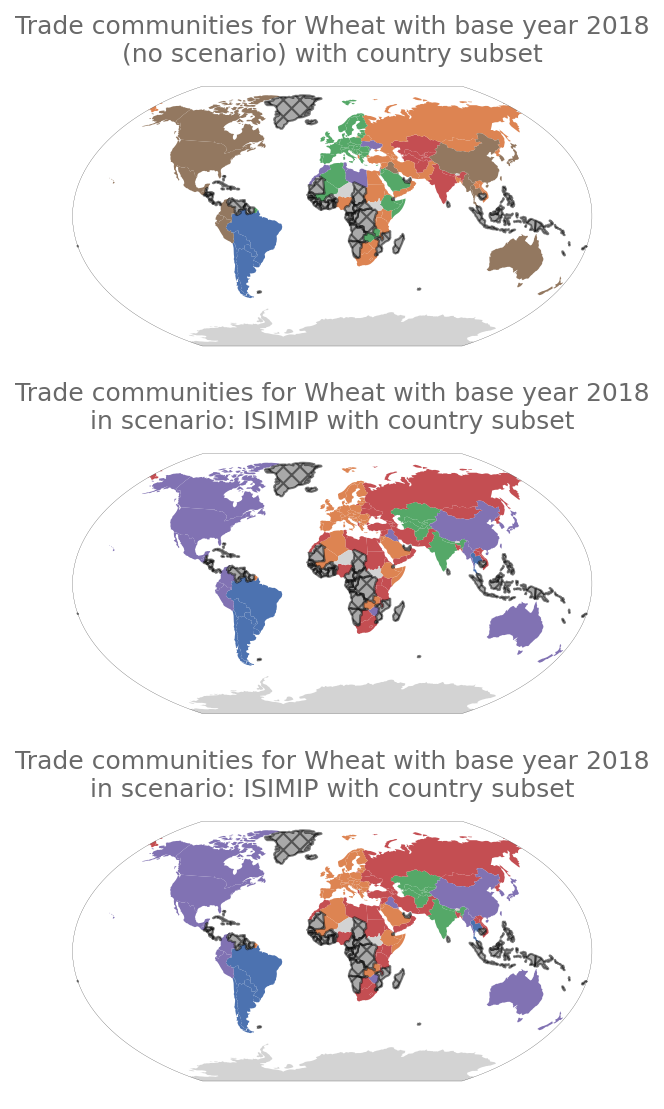

In [21]:
comparison.plot_all_trade_communities()

Now, China and Russia have persistent colours between scenarios making it easier to analyse the map.

We can also try to quantify how different the communities are in each scenario for each country.
The natural way of doing this is the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
It measures the similarity between two sets.
So for each country we can compute a Jaccard distance (1-Jaccard index)
showing us by how much for each country their community changed.

The figure sizes/titles etc., are subject to change, this is just a prototype.
We assume that the first passed scenario (index 0 in the list) is the base scenario against which we're comparing.
A round-robin can be easily executed by simply calling the postprocessing class in a loop over all pairs.

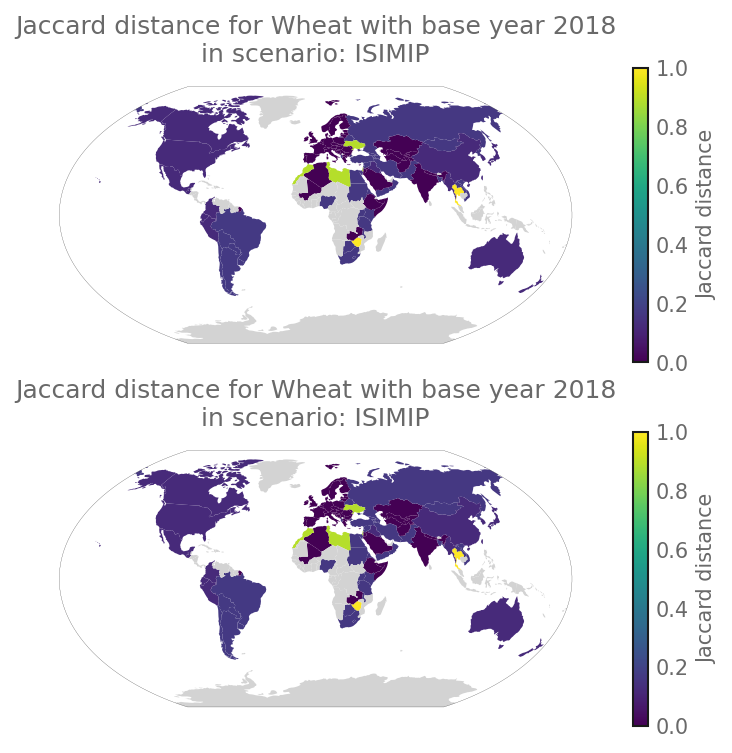

In [22]:
comparison.plot_community_difference()

Let's now use some quantitative methods of comparing graphs.
The following prints a table with 3 currently implemented metrics.

Frobenius is a standard frobenius norm ||A1-A2|| where A1 is the adjacency matrix of graph 1 and A2 an adj. matrix of graph 2.

Markov is a Eucledean distance between stationary probability distribution vectors of each graph.
The idea here is this: we change the adjacency matrix to a right stochastic matrix, which means that if there is a random walker at node 'n' he will randomly choose one of the neighbours of 'n' with probability proportional to the weight at the edge n--neighbour. Imagine that this walker continues to roam the graph ad infinitum.
What would be the expected probability of finding the walker at node 'n' at any given time? Intuitively nodes that have high valued incoming edges will have this probability high, and nodes with high valued outgoing edges will have this probability low. More info here: https://en.wikipedia.org/wiki/Stochastic_matrix
Having those stationary distributions computed for each network we can compute a vector distance between them. This is our 'markov' metric.

Entropy rate is next and it is related to 'markov' as it is computed from those stationary distributions as well. More info here: https://en.wikipedia.org/wiki/Entropy_rate
Technicalities aside, the idea is that the entropy rate measures the complexity of the process (we're assming markovian random walk again) and so we can compute a simple difference between entropy rates for the graphs giving as a measure of increased (decreased) complexit in nats (unit of information).


In [23]:
comparison.print_distance_metrics()

***| Graph distance to the base scenario |***
╒═══════════════╤═════════════╤═════════════╤════════════════╕
│   Scenario ID │   Frobenius │      Markov │   Entropy rate │
╞═══════════════╪═════════════╪═════════════╪════════════════╡
│             1 │   3.098e+06 │ 1.13205e-15 │    -1.9984e-15 │
├───────────────┼─────────────┼─────────────┼────────────────┤
│             2 │   3.098e+06 │ 1.13205e-15 │    -1.9984e-15 │
╘═══════════════╧═════════════╧═════════════╧════════════════╛


We can also plot these values; however, Frobenius evidently is in a different order of magnitude than the other metrics and so such a plot might not be very informative:

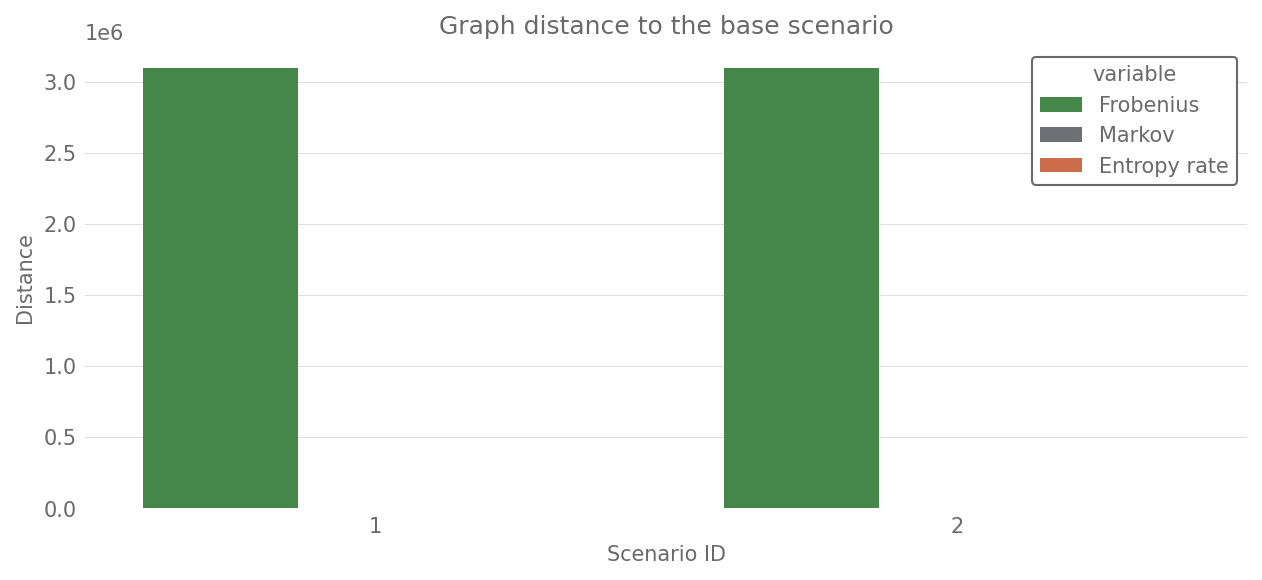

In [24]:
comparison.plot_distance_metrics()

Thus, we introduce a parameter "frobenius" (name subject to change) that takes on the values "relative", "ignore" or None. None is the above.

"ignore" will simply remove it from the plot:

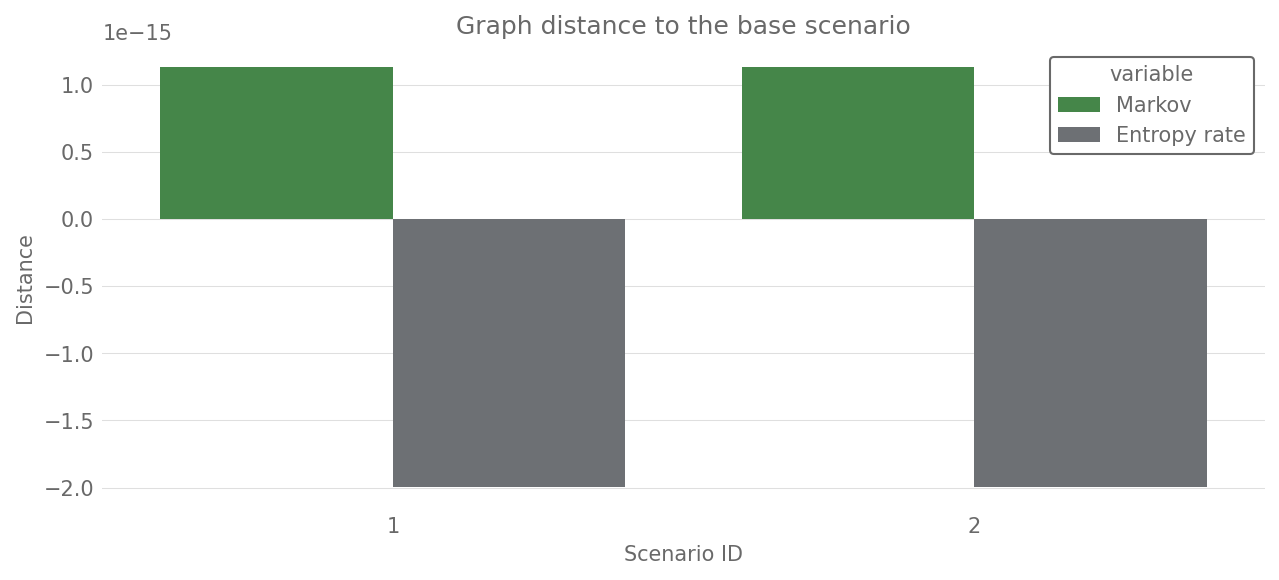

In [25]:
comparison.plot_distance_metrics(frobenius="ignore")

"relative" will compute all metrics relatively to the highest computed value in a given category:

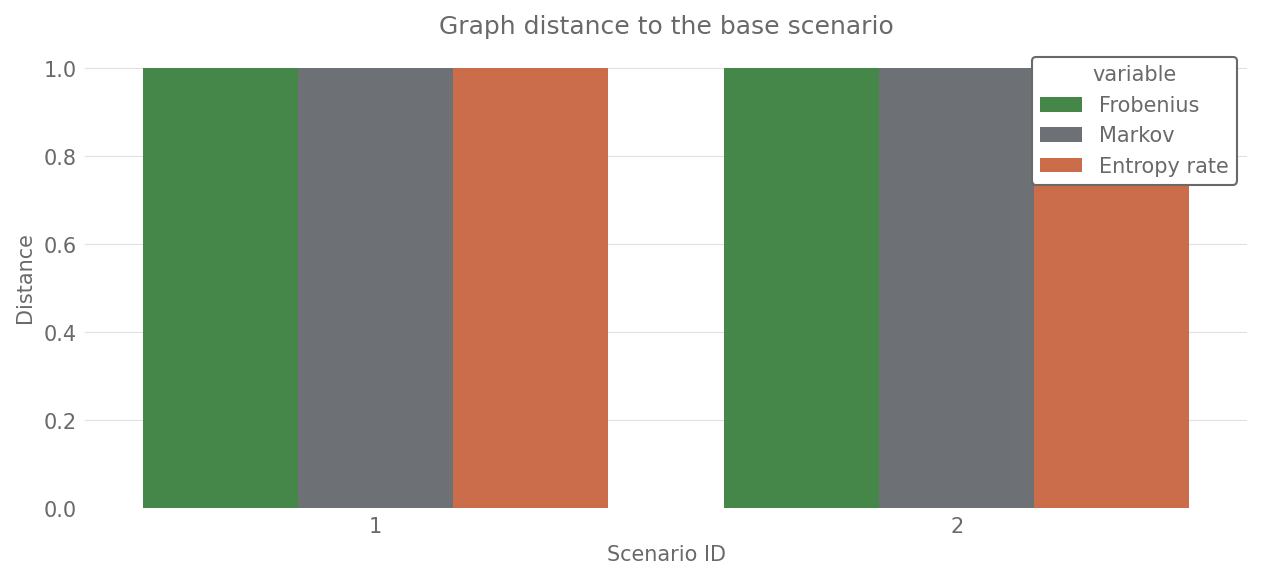

In [26]:
comparison.plot_distance_metrics(frobenius="relative")

We can also study the degree centralities (in and out) for all networks:

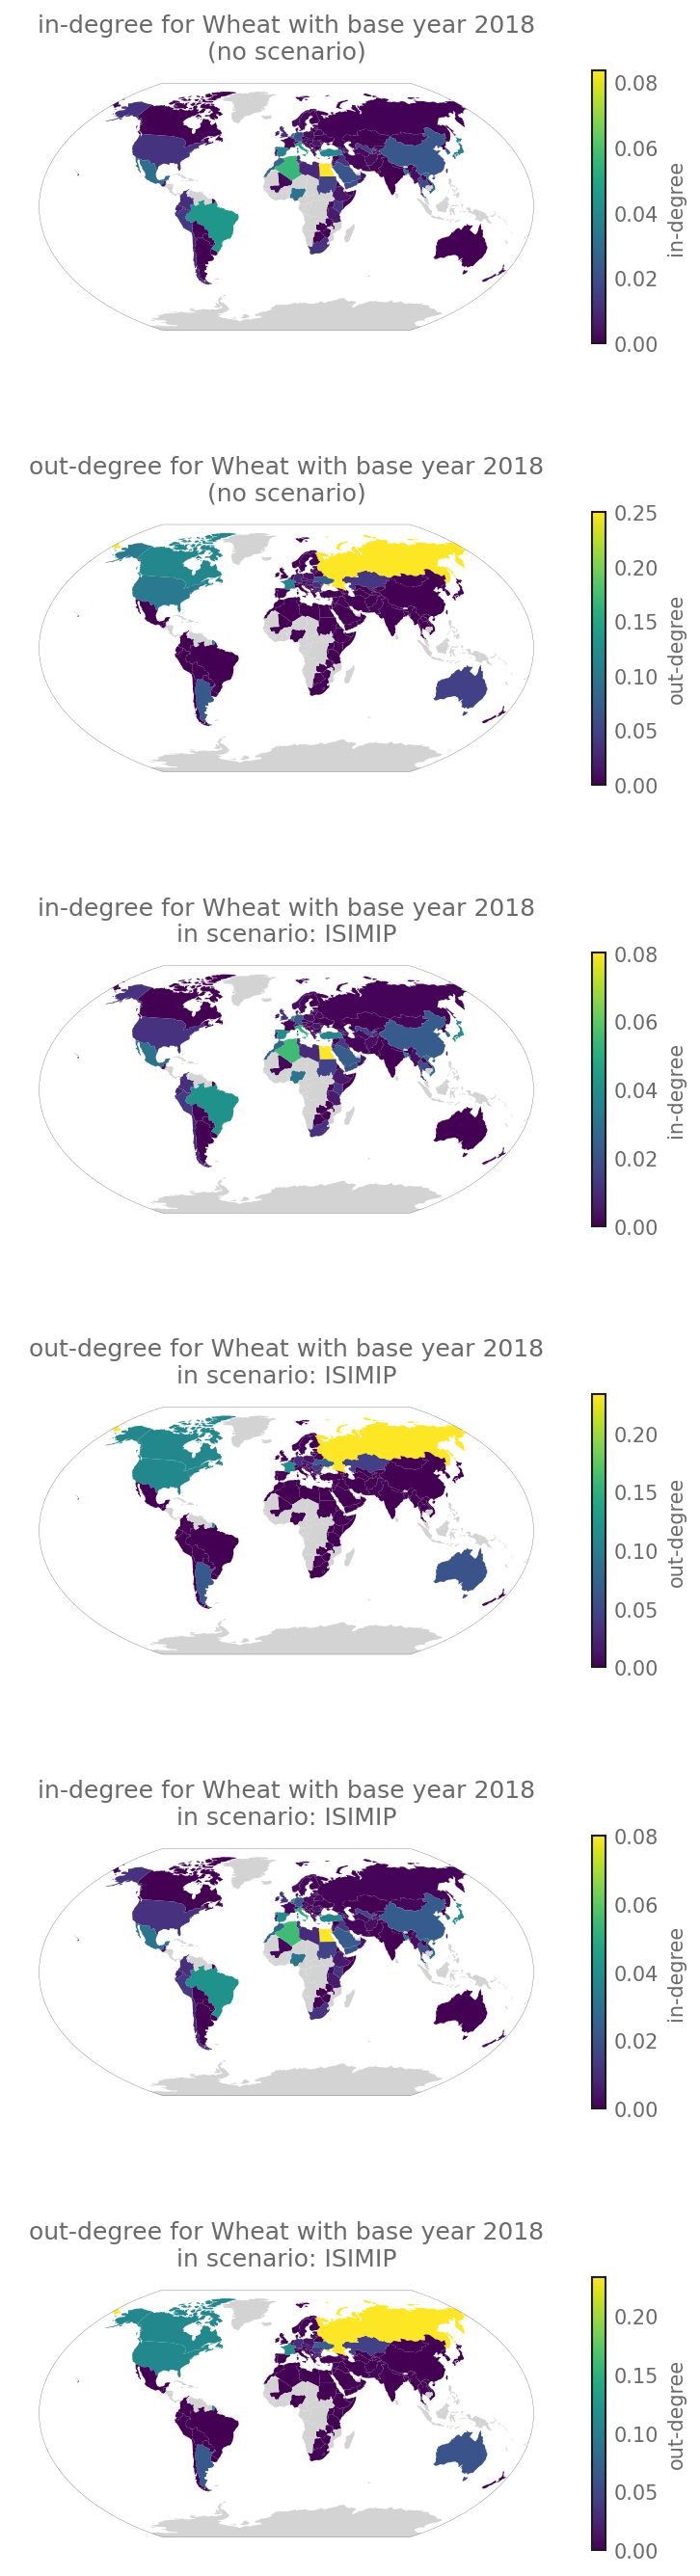

In [27]:
comparison.plot_centrality_maps(figsize=(5, 25), shrink=0.2)

and in tabulated form, global:

In [28]:
comparison.print_global_centrality_metrics(index=False)

***| Degree centrality metrics for each scenario |***
╒═════════════╤═════════════╤═════════════╤═════════════╤══════════════╤══════════════╤══════════════╤══════════════╕
│ Smallest    │    Smallest │ Largest     │     Largest │ Smallest     │     Smallest │ Largest      │      Largest │
│ in-degree   │   in-degree │ in-degree   │   in-degree │ out-degree   │   out-degree │ out-degree   │   out-degree │
│ country     │       value │ country     │       value │ country      │        value │ country      │        value │
╞═════════════╪═════════════╪═════════════╪═════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ Argentina   │           0 │ Egypt       │   0.0837674 │ Afghanistan  │            0 │ Russia       │     0.250466 │
├─────────────┼─────────────┼─────────────┼─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ Argentina   │           0 │ Egypt       │   0.0801043 │ Afghanistan  │            0 │ Russia       │     0.2333   │
├─

and for each community in each scenario. Note: the community ID doesn't mean much, it is just the index in the list scenario.trade_communities

In [29]:
comparison.print_per_community_centrality_metrics(index=False)

***| Degree centrality metrics for the scenario with ID: 0 |***
╒═════════════╤═════════════╤═════════════╤═════════════╤══════════════╤══════════════╤══════════════╤══════════════╕
│ Smallest    │    Smallest │ Largest     │     Largest │ Smallest     │     Smallest │ Largest      │      Largest │
│ in-degree   │   in-degree │ in-degree   │   in-degree │ out-degree   │   out-degree │ out-degree   │   out-degree │
│ country     │       value │ country     │       value │ country      │        value │ country      │        value │
╞═════════════╪═════════════╪═════════════╪═════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ Argentina   │ 0           │ Brazil      │   0.0443705 │ Bolivia      │            0 │ Argentina    │    0.0699874 │
├─────────────┼─────────────┼─────────────┼─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ Laos        │ 2.12059e-06 │ Egypt       │   0.0837674 │ Albania      │            0 │ Russia       │    0.25

We can plot a community satisfaction index, taken from [here](https://www.mdpi.com/2304-8158/12/2/271).

It measures how much of each country's import is satisfied by their community.

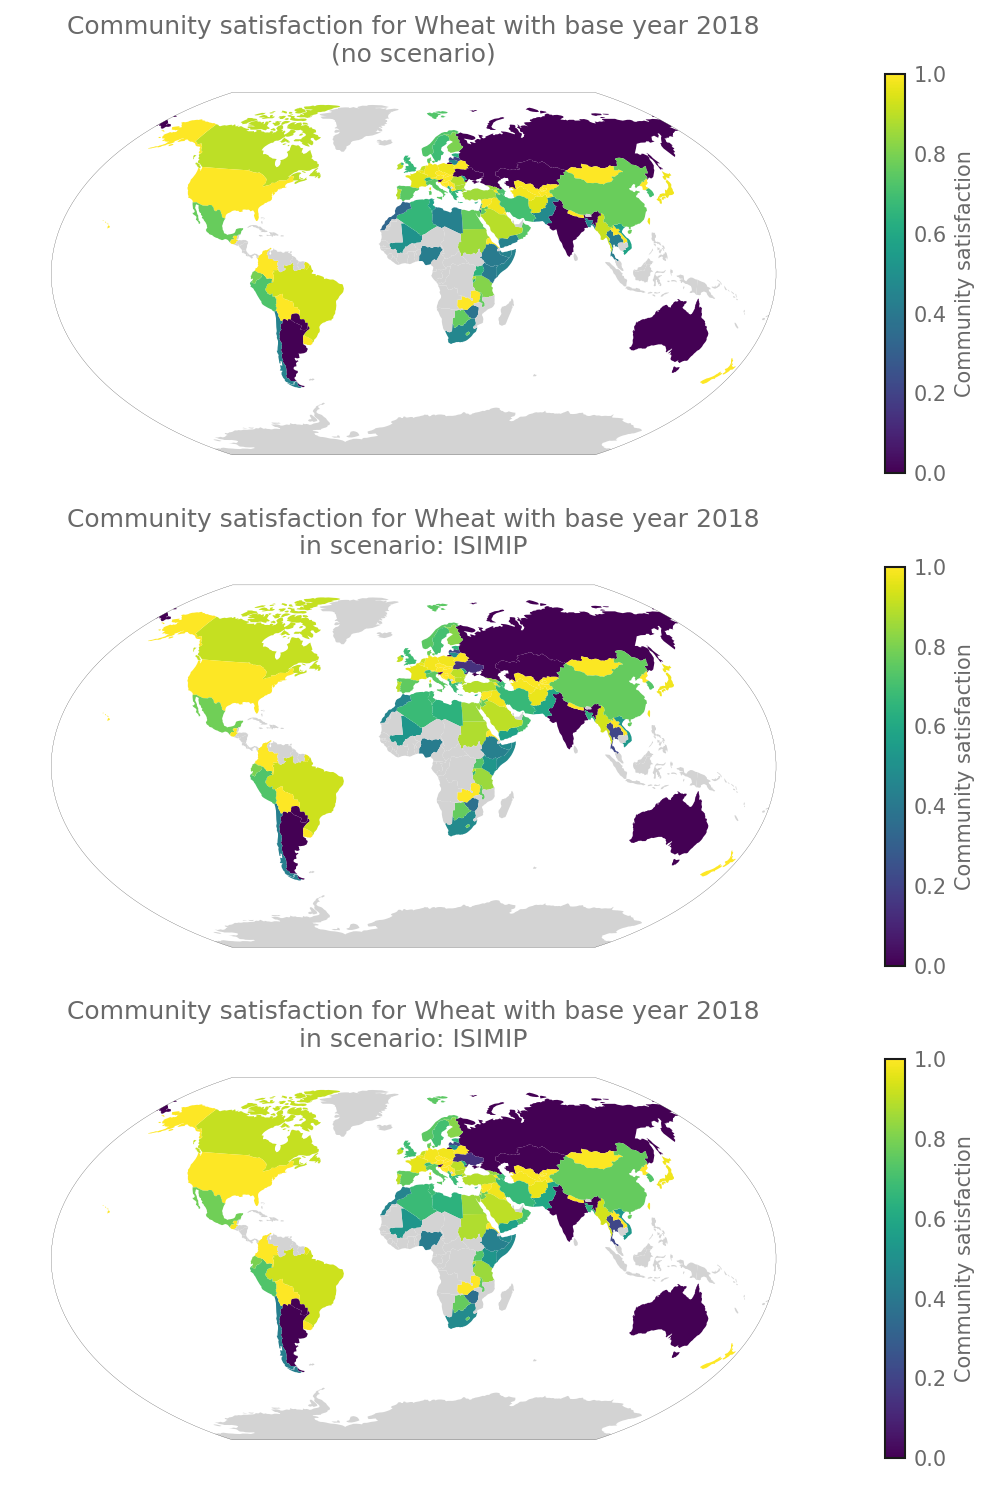

In [30]:
comparison.plot_community_satisfaction(figsize=(10, 10))

and the difference from base scenario:

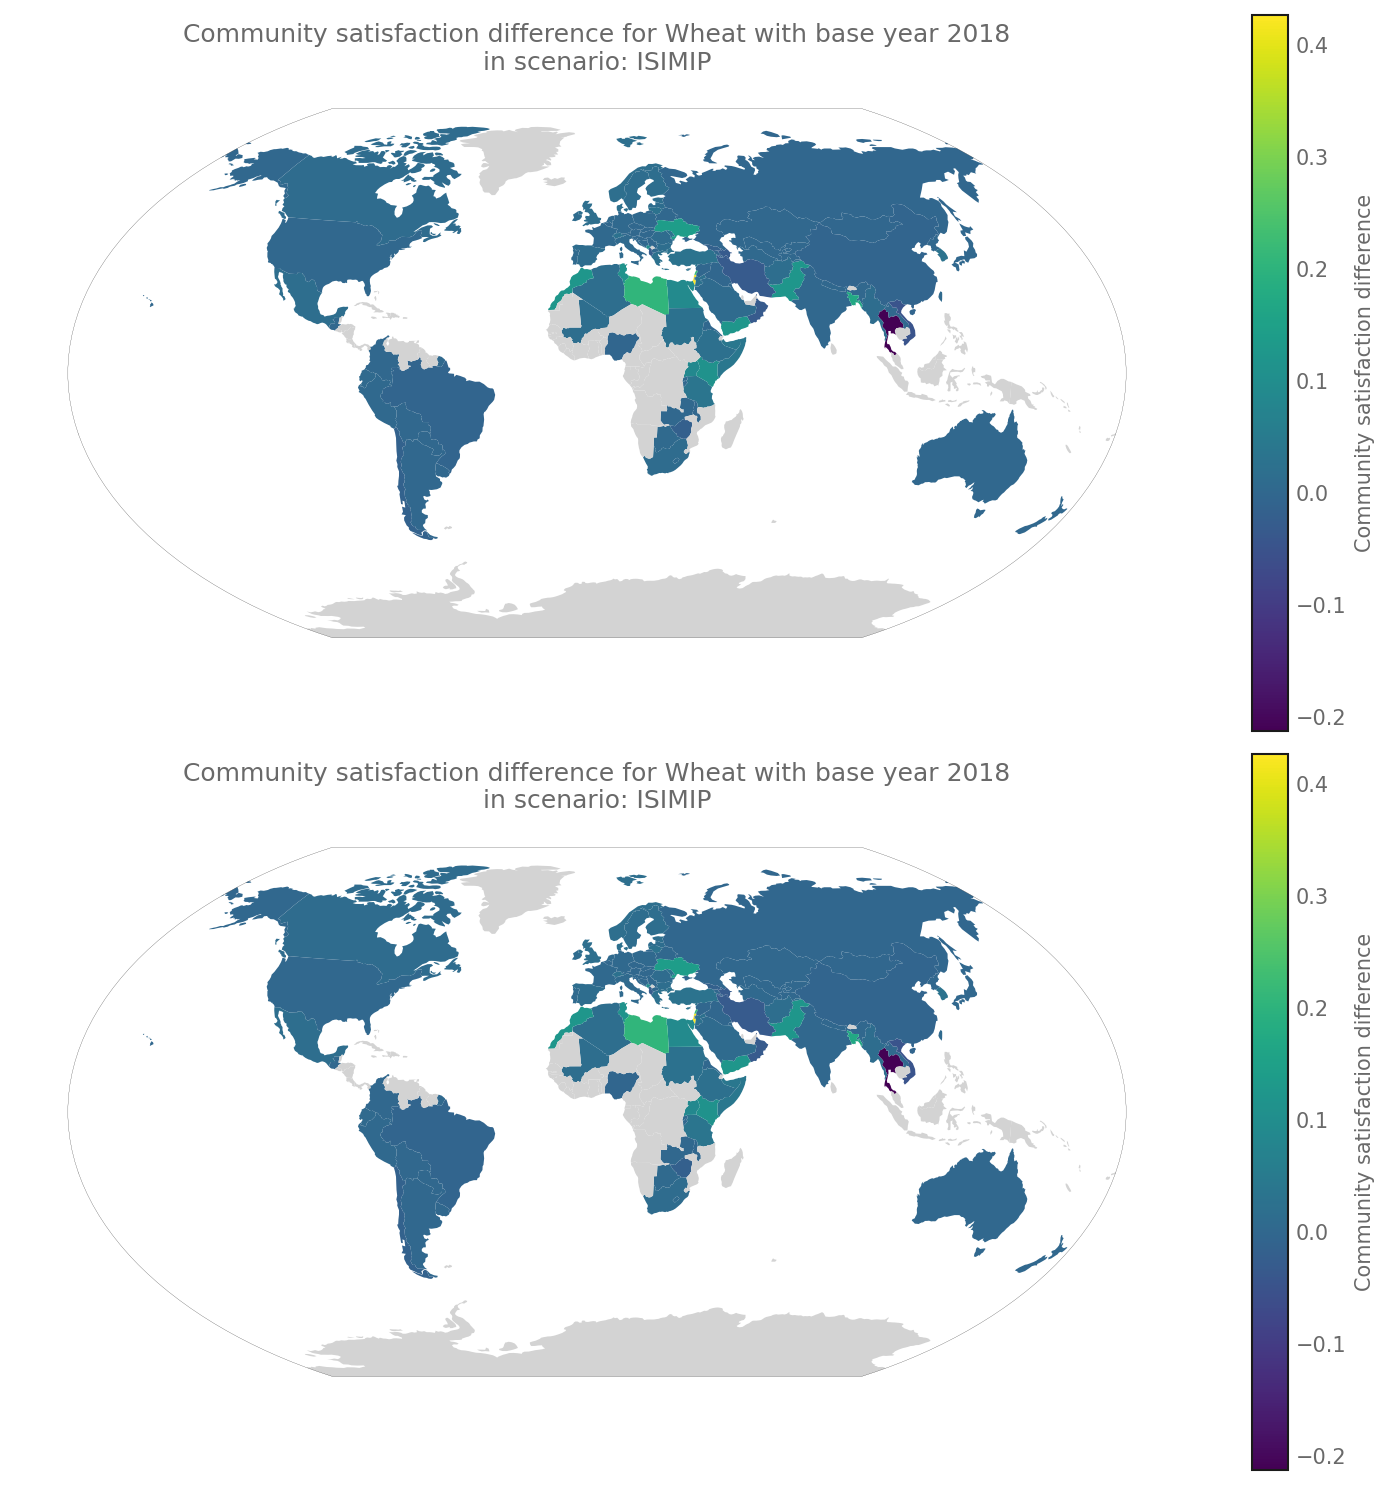

In [31]:
comparison.plot_community_satisfaction_difference(figsize=(10, 10))

We also can look at country's stability index, which is a measure of how easily each country can replace their import partners (same paper as community satisfaction).

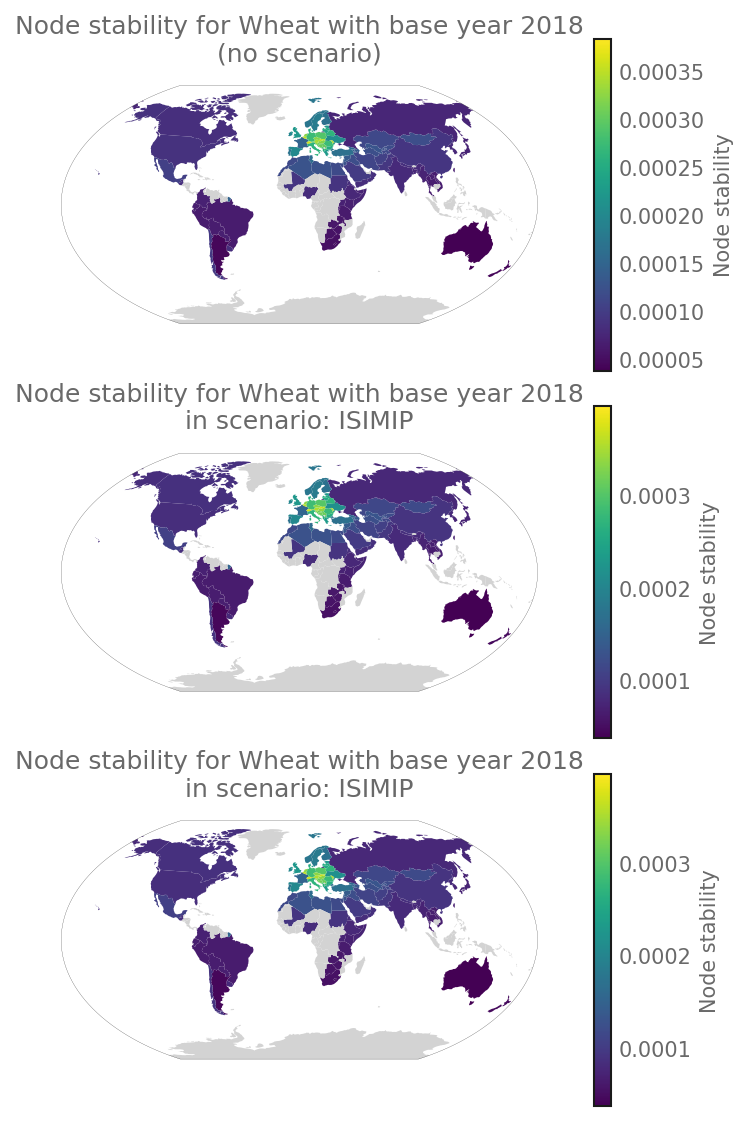

In [32]:
comparison.plot_node_stability() # figsize works here too of course

However, the units here are kind of ¯\\_(ツ)_/¯, so it might be difficult to interpet it.

For this reason we can look at the *relative* change of this metric:

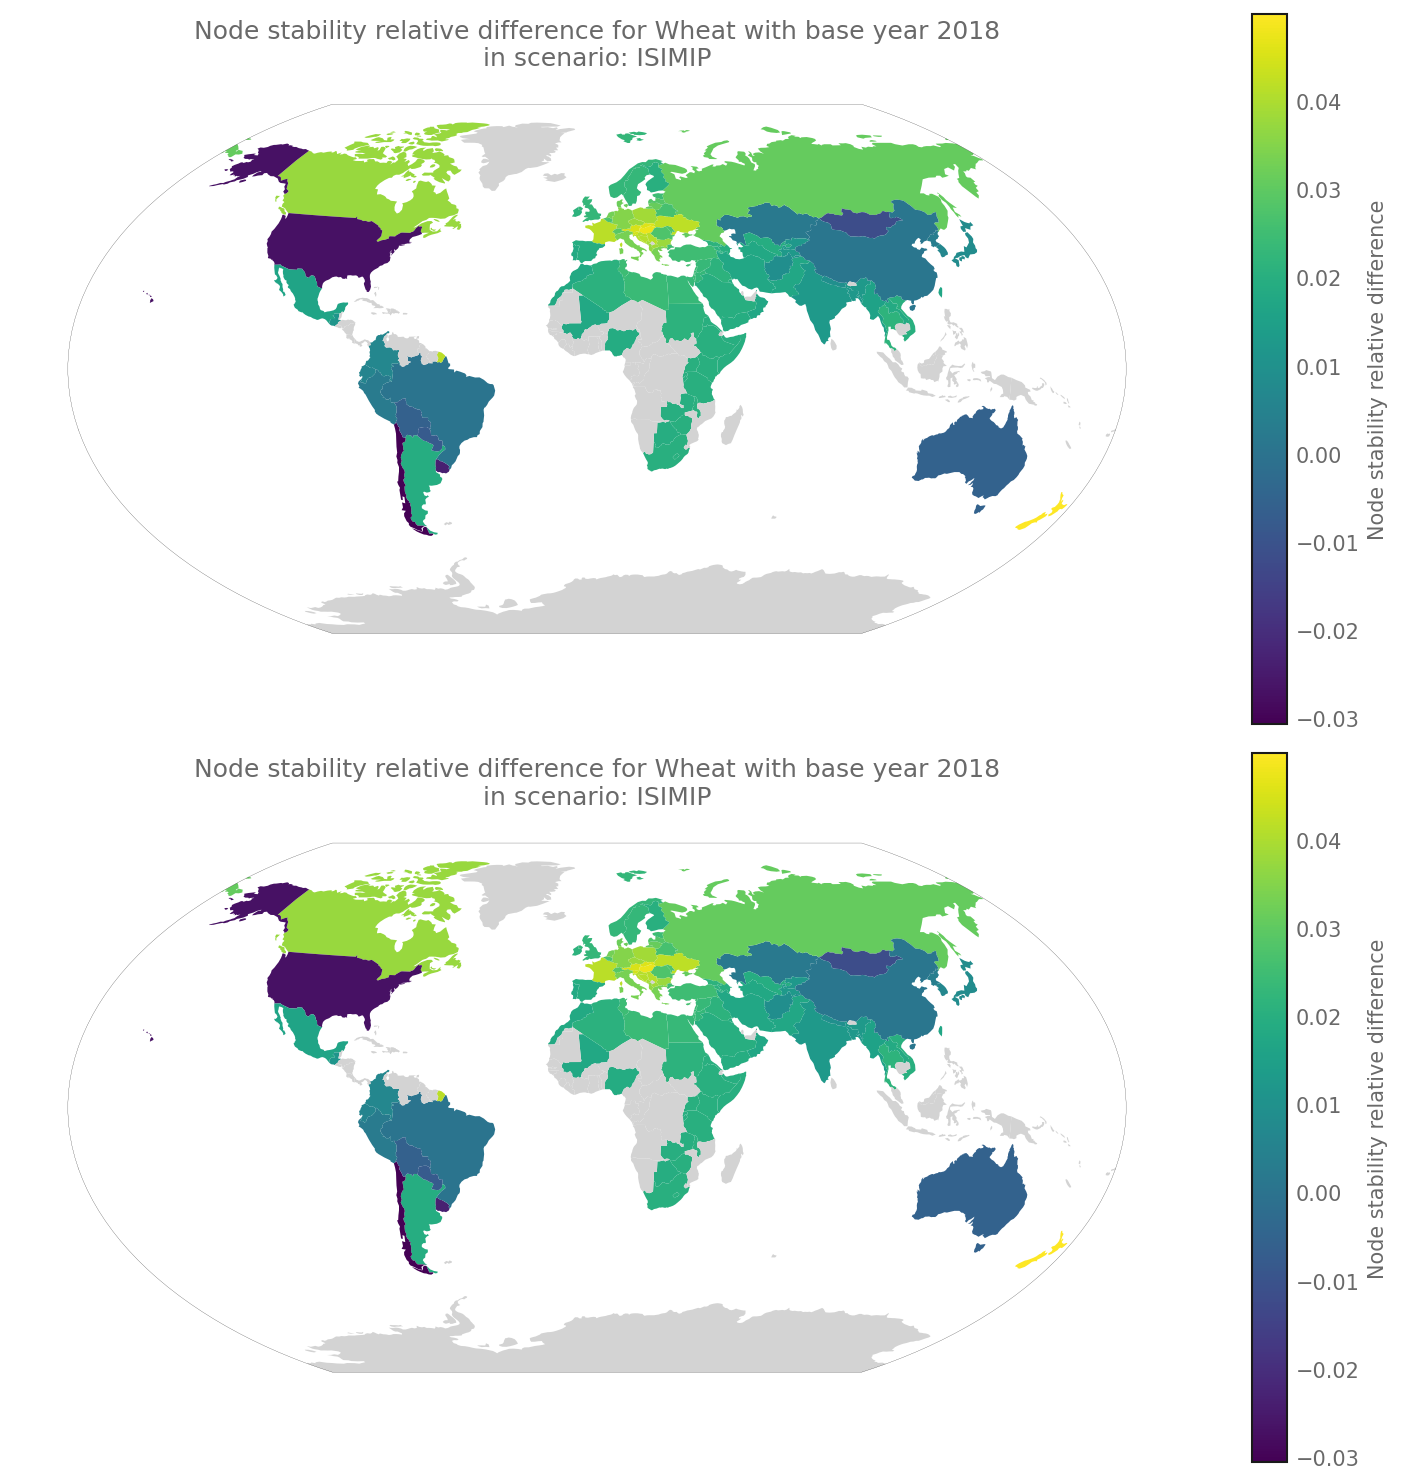

In [33]:
comparison.plot_node_stability_difference(figsize=(10, 10))

Another important aspect of a network is its resilience to attacks, and we can see that as well:

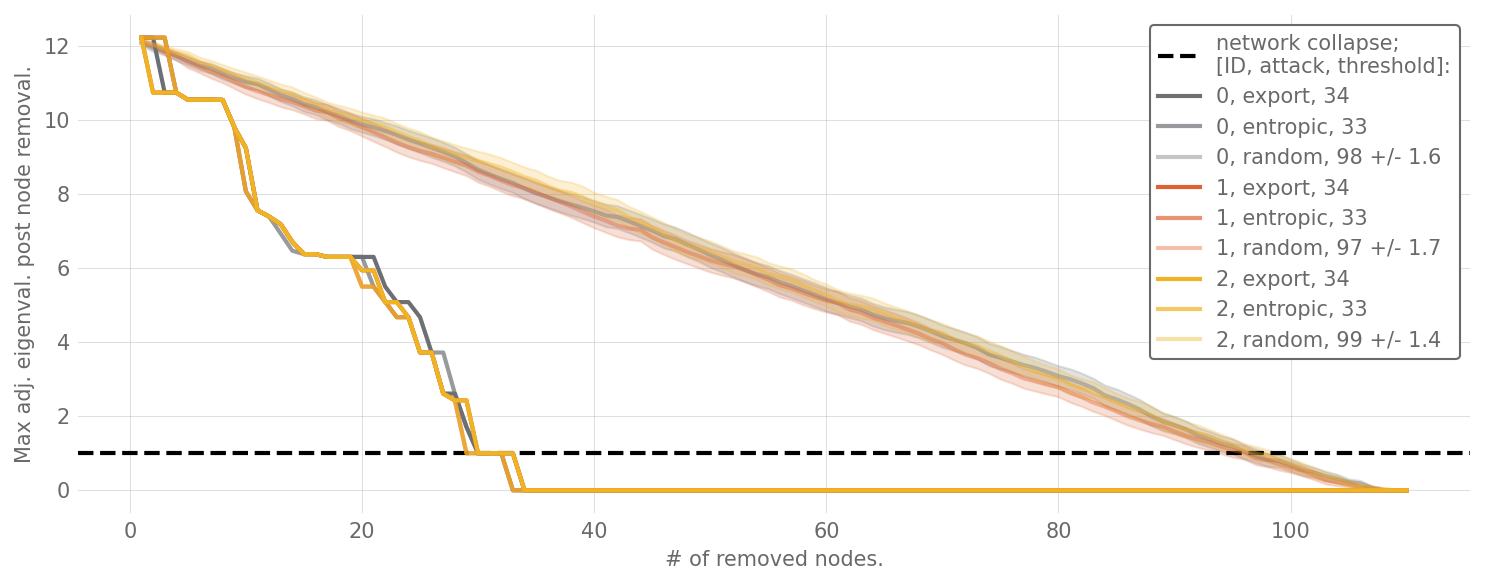

In [34]:
comparison.plot_attack_resilience()

This is based on [this paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.058701).

In there, the authors show that we can approximate the network percolation threshold with the largest eigenvalue of a particular matrix (details in paper/code docs).

We consider three modes of attack: export based, entropic degree based, and random.

Export based means that we remove nodes in order of their out-degree (relative exporting importance), highest to lowest.

Entropic degree based is like the above but the measure of importance is the entropic degree taken from [here](https://www.sciencedirect.com/science/article/abs/pii/S1874548209000031).
In short, it is a measure developed for power grids to identify most crucial nodes.

Random means we remove the nodes at random. This also requires us to recompute this many times to get decent statistic (controlled by a parameter passed to postprocessing class). That's why the 'random' curves have error bands and a '+/-' next to their threshold value.
The error band and threshold error is controlled by a sigma parameter (passed directly to the function). By default we're computing a [2-sigma result](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

In the legedn: ID refers to the scenario ID as passed into the postprocessing class, next is the attack type and finally the threshold value. This threshold tells us how many nodes need to be removed to collapse the network.

Finally, we can look at other general metrics (including the percolation threshold) of the graphs:

In [35]:
comparison.print_network_metrics()

╒═══════════════╤═══════════════╤══════════════╤══════════════╤═══════════════════╤═════════════════╤═════════════════╤═════════════╕
│   Scenario ID │   Betweenness │   Clustering │   Efficiency │   Entropic-attack │   Export-attack │ Random-attack   │   Stability │
│               │               │              │              │         threshold │       threshold │ threshold       │             │
╞═══════════════╪═══════════════╪══════════════╪══════════════╪═══════════════════╪═════════════════╪═════════════════╪═════════════╡
│             0 │    0.00985003 │   0.00163397 │     0.222011 │                33 │              34 │ 98 +/- 0.79     │ 0.000136678 │
├───────────────┼───────────────┼──────────────┼──────────────┼───────────────────┼─────────────────┼─────────────────┼─────────────┤
│             1 │    0.00986779 │   0.00174447 │     0.218578 │                33 │              34 │ 97 +/- 0.83     │ 0.000141145 │
├───────────────┼───────────────┼──────────────┼──────────────

Also available in the long form:

In [36]:
comparison.print_network_metrics(wide=False)

╒════╤═══════════════╤═════════════════╤════════════════════════╕
│    │   Scenario ID │ Metric          │ Value                  │
╞════╪═══════════════╪═════════════════╪════════════════════════╡
│  0 │             0 │ Efficiency      │ 0.22201050995299454    │
├────┼───────────────┼─────────────────┼────────────────────────┤
│  1 │             1 │ Efficiency      │ 0.21857833101181046    │
├────┼───────────────┼─────────────────┼────────────────────────┤
│  2 │             2 │ Efficiency      │ 0.21857833101181046    │
├────┼───────────────┼─────────────────┼────────────────────────┤
│  3 │             0 │ Clustering      │ 0.0016339743072316959  │
├────┼───────────────┼─────────────────┼────────────────────────┤
│  4 │             1 │ Clustering      │ 0.001744466865684454   │
├────┼───────────────┼─────────────────┼────────────────────────┤
│  5 │             2 │ Clustering      │ 0.001744466865684454   │
├────┼───────────────┼─────────────────┼────────────────────────┤
│  6 │    